# Neuronal Networks and Deep Learning

## Stacked Denoising Autoencoder

by 

[__Michael Granitzer__ (michael.granitzer@uni-passau.de)]( http://www.mendeley.com/profiles/michael-granitzer/)

with examples taken from the scikit-learn documentation under http://scikit-learn.org/stable/


__License__

This work is licensed under a [Creative Commons Attribution 3.0 Unported License](http://creativecommons.org/licenses/by/3.0/)

#Table of Contents
* [Neuronal Networks and Deep Learning](#Neuronal-Networks-and-Deep-Learning)
	* [Stacked Denoising Autoencoder](#Stacked-Denoising-Autoencoder)
* [3. Introduction](#3.-Introduction)
* [4. Theory](#4.-Theory)
* [5. Toy Example](#5.-Toy-Example)
	* [5.1 Data First: A Circle and a Sphere](#5.1-Data-First:-A-Circle-and-a-Sphere)
	* [5.2 The Autoencoder](#5.2-The-Autoencoder)
		* [5.2.1 Training and Testing on a circle](#5.2.1-Training-and-Testing-on-a-circle)
		* [5.2.2 Training a sphere](#5.2.2-Training-a-sphere)
		* [5.2.3 Bi-Spherical Data](#5.2.3-Bi-Spherical-Data)
	* [5.3 Training and testing elastic learning](#5.3-Training-and-testing-elastic-learning)
		* [5.3.1 Functional test of elastic learning](#5.3.1-Functional-test-of-elastic-learning)
		* [5.3.2 Training an Elastic Autoencoder on a Sphere](#5.3.2-Training-an-Elastic-Autoencoder-on-a-Sphere)
		* [5.3.3 Training an Elastic Autoencoder on a Bi-Sphere](#5.3.3-Training-an-Elastic-Autoencoder-on-a-Bi-Sphere)
	* [5.4 Truly Elastic training - no weight updates to previous units](#5.4-Truly-Elastic-training---no-weight-updates-to-previous-units)
		* [5.4.1 Embedding a sphere - looks like traditional AEs and Elastic1](#5.4.1-Embedding-a-sphere---looks-like-traditional-AEs-and-Elastic1)
		* [5.4.2 Embedding a Bi-Sphere - Elastic 2 choose directions of greatest variance (!?!)](#5.4.2-Embedding-a-Bi-Sphere---Elastic-2-choose-directions-of-greatest-variance-%28!?!%29)


# 3. Introduction

This notebook outlines Stacked Denoising Autoencoders through small examples using python.

# 4. Theory

TODO:

# 5. Toy Example

In this toy example we will take a simple 2D circle and 3D sphere and learn it using a stacked denoising autoencoder.

In [63]:
%pylab inline
import numpy as np
import math
import pylab as pl
from mpl_toolkits.mplot3d import Axes3D
import mpld3
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize']=(14,6)

Populating the interactive namespace from numpy and matplotlib


## 5.1 Data First: A Circle and a Sphere

In [53]:
def circle(r=[1.0, 1.0], num=1000, circle=False, seed=1357):
    d = np.zeros((2,num))
    state = np.random.RandomState(seed)
    for i in xrange(num):
        phi = 2*math.pi*state.rand() # x y angle
        d[0,i],d[1,i] = r[0]*math.cos(phi), r[1] * math.sin(phi)
    return d

def sphere(r=[1.0, 1.0, 1.0], num=1000, circle=False, seed=1357):
    d = np.zeros((3, num))
    state = np.random.RandomState(seed)
    for i in xrange(num):
        phi = 2*math.pi*state.rand() # x y angle
        theta = 2*math.pi*state.rand() # x y angle
        sin_theta = math.sin(theta)
        d[1,i],d[0,i],d[2,i] =r[1] * sin_theta * math.sin(phi) , r[0] * sin_theta* math.cos(phi), r[2]*math.cos(theta)
    return d

def scatter3D(data, fig=None, pos=111):
    if fig is None:
        fig = plt.figure()
    ax = fig.add_subplot(pos, projection='3d')
    ax.scatter(data[0], data[1], data[2])
    return fig

def plotae(ae, data):
    pass

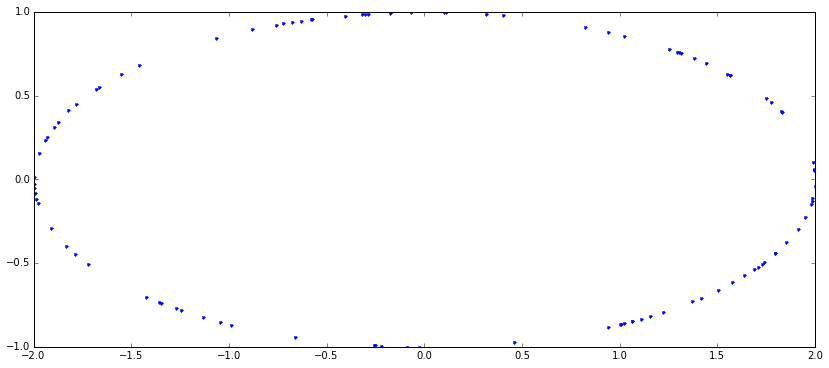

In [7]:
d = circle([2.0,1.0],100)
pl.plot(d[0,],d[1,],".")
pl.show()

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


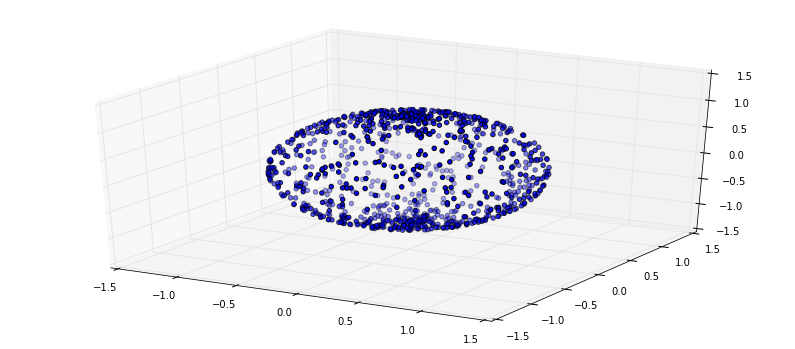

In [9]:
data = sphere([1.0,1.0,1.0],1000)
scatter3D(data).show()

## 5.2 The Autoencoder

The 'tanh' function as non-linear output scaling transfer function:

$$
o(x) = \frac{e^{wx} - e^{-{wx}}}{e^{wx} + e^{-{wx}}}
$$

Backpropagation training consists of (see training_step_stochastic for the implementation)

1. calculating the encoding of an example $x$ based on the model with Weights $W$ and bias $b$ as 
$$
y = o_{W,b}(x)
$$
2. reconstructing the example $x$ based on the model with Weights $W^T$ and bias $b'$ as
$$
z = o_{W^{t},b'}(y)
$$
3. calculating the error between example $x$ and reconstruction of $x$ as
$$
\delta_o = (x-z)
$$
4. updating the model by going from the reconstructed output $z$ to the hidden layer representation $y$ to the input layer $x$  
   - Output Layer:
        $$
        b'= b'+ \eta * (1-z^2) * \delta_o
        $$
        $$
        W.T= W.T + \eta * ((1-z^2) \cdot \delta_o) * y^T
        $$
   - Hidden Layer with error $\delta_h = (W * \delta_o) * (1-z^2)$
   $$
    b = b + \eta * (1-y^2) * \delta_h
   $$
   $$
    W = W + \eta * ((1-y^2) \cdot \delta_h)*x^T
    $$

see [backprop description](http://www.willamette.edu/~gorr/classes/cs449/backprop.html) for details. Note the difference between $\cdot$ as Pointwise prodcut and $*$  as matrix multiplication.


In [71]:
class Autoencoder(object):

    def __init__(self, in_size, hidden_size):
        self.w = np.random.random((hidden_size, in_size))
        self.b = np.random.random(hidden_size)
        self.b_rec = np.random.random(in_size)
        
    def out(self, x,w,b):
        # function that calculates the output of the network
        wx = np.sum(x * w,1) +b
        e_x = np.exp(wx)
        e_mx = np.exp(-1.0*wx)
        return (e_x-e_mx)/(e_x+e_mx)

    def encode(self, x): 
        return self.out(x,self.w,self.b)

    def decode(self, x): 
        return self.out(x,self.w.T,self.b_rec)

    def endecode(self, x):
        return self.decode(self.encode(x))
    
    def train_step_stochastic(self, x, eta=0.1):
        # todo: use elastic for learning
        # data is a 1d array with exactly 1 example
        # forward phase
        y = self.encode(x) # input to hidden layer activation
        z = self.decode(y) # hidden layer to output layer activation. Note that the weights are shared
        err = x - z # error at the ouput layer
        self.b_rec = self.b_rec + eta * (1 - z**2) * err # update the bias terms into the reconstruction layer
        dwt = eta * np.matrix(((1 - z**2) * err)).T * np.matrix(y)  # a matrix update. one row for every neuron in the hidden layer
        err_h = np.sum(self.w * err,1)  # error of the hidden layer.
        self.b = self.b + eta * (1 - y**2) * err_h # update the bias terms into the hidden layer.
        self.w = self.w + np.asarray(eta * np.matrix((1 - y**2) * err_h).T * np.matrix(x) + dwt.T) #
        return err
    
   
    def train(self, data, epochs=20, eta=0.1, callback=None):
        for j in xrange(epochs):
            sum_err = 0
            for i in xrange(data.shape[1]):
                err = self.train_step_stochastic(data[:,i], eta)
                sum_err += np.sum(err**2)/data.shape[1]
            if callback!=None:
                callback(j,sum_err)
        return self
    
    def decode_all(self, data):
        return np.array([self.decode(x) for x in data.T]).T
    
    def encode_all(self, data):
        return np.array([self.encode(x) for x in data.T]).T

    def plot(self,data, hidden_grid=False):
        if data.shape[0]==2:
            hidden = self.encode_all(data) #np.array([encode(x,w,b,b_rec) for x in data.T]).T
            if hidden_grid:
                hidden = np.linspace(-2,2,data.shape[1])
            reconstructed = self.decode_all(hidden) # np.array([decode(x,w,b,b_rec) for x in hidden.T]).T
            # plot the encoded points
            fig, ax = plt.subplots(1,2, figsize=(16,6))
            ax[0].plot(data[0],data[1],".")
            ax[0].set_title("data")
            pts = ax[1].scatter(reconstructed[0], reconstructed[1], marker="+", c=hidden, cmap=cm.bwr )
            ax[1].set_title("reconstruction")
            colorbar(pts)
            return fig
        elif data.shape[0]==3:
            hidden = self.encode_all(data) #np.array([encode(x,w,b,b_rec) for x in data.T]).T
            if hidden_grid:
                hidden = np.linspace(-2,2,data.shape[1])
            reconstructed = self.decode_all(hidden) # np.array([decode(x,w,b,b_rec) for x in hidden.T]).T
            fig = plt.figure(figsize=(16,6))
            ax = fig.add_subplot(131)
            ax.plot(hidden[0],hidden[1],".")
            ax.set_title("Embedding")
            ax = fig.add_subplot(132, projection='3d')
            ax.scatter(data[0], data[1], data[2])
            ax.set_title("Original Data")
            ax = fig.add_subplot(133, projection='3d')
            ax.scatter(reconstructed[0], reconstructed[1], reconstructed[2])
            ax.set_title("Reconstructed data")
            return fig
        else: 
            return None
   
    
    
def cb_print(epoch,sse):
    if epoch%5==0:
        print(epoch, " sse=",sse)  

### 5.2.1 Training and Testing on a circle

**Circle:** The first experiment is a simple circle reduced to a 1D space. We can see that the hidden unit encodes a diameter. the direction depends on the initatlization and since there is no ability for reconstruction, the network can only retain 1 direction.

(0, ' sse=', 0.19604737355536486)
(5, ' sse=', 0.12804716405037136)
(10, ' sse=', 0.12801770185610531)
(15, ' sse=', 0.12792778005289621)
(20, ' sse=', 0.12777851537179274)
(25, ' sse=', 0.12759705932601811)
(30, ' sse=', 0.12741297450408115)
(35, ' sse=', 0.12724356454753841)


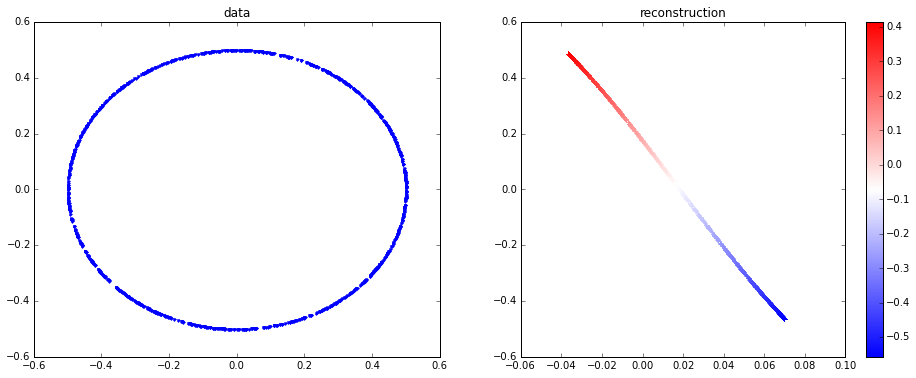

In [72]:
data = circle([0.5,0.5],1000)
ae = Autoencoder(data.shape[0],1)
ae.train(data, epochs=40, callback = cb_print, eta=0.01)
ae.plot(data).show()

**Eclipse:** next we try an eclipse. The cirlce is streched in  on direction. This direction has the greatest variance and the network should capture that direction. 

(0, ' sse=', 0.1271092592612931)
(5, ' sse=', 0.0056445687662943118)
(10, ' sse=', 0.0056219023470761463)
(15, ' sse=', 0.0056006144463505575)
(20, ' sse=', 0.0055806267548486818)
(25, ' sse=', 0.0055618393100177821)
(30, ' sse=', 0.0055441615004470871)
(35, ' sse=', 0.005527511160851247)


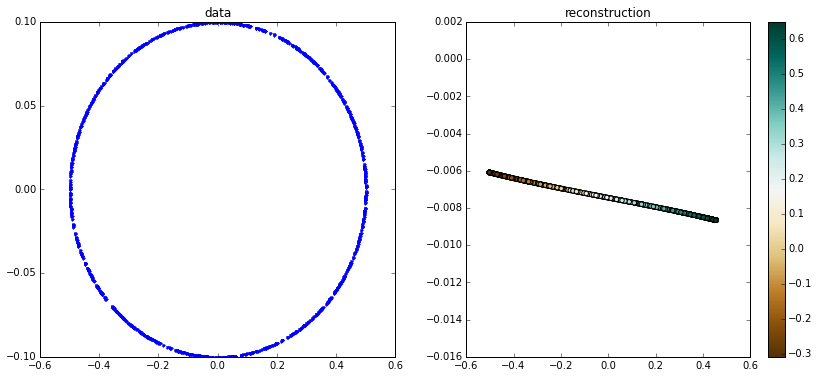

In [619]:
data = circle([0.5,0.1],1000)
ae = Autoencoder(data.shape[0],1)
ae.train(data, epochs=40, callback = cb_print, eta=0.01)
ae.plot(data).show()

(0, ' sse=', 0.11699069639392981)
(5, ' sse=', 0.0053911996250388308)


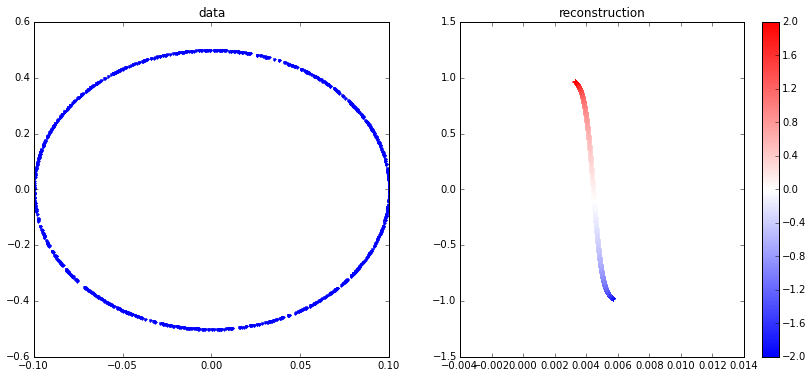

In [79]:
data = circle([0.1,0.5],1000)
ae = Autoencoder(data.shape[0],1)
ae.train(data, epochs=10, callback = cb_print, eta=0.01)
ae.plot(data,True).show() #show the full range of hidden units

### 5.2.2 Training a sphere

(2, 3)
(0, ' sse=', 0.31150121503601663)


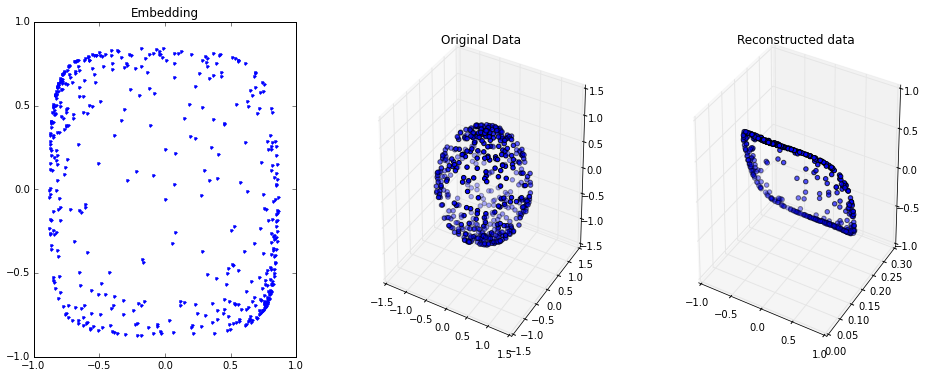

In [73]:
data = sphere([1.0,1.0,1.0],500)
ae = Autoencoder(data.shape[0],2)
print ae.w.shape
ae.train(data, epochs=2, callback = cb_print)
ae.plot(data).show()

### 5.2.3 Bi-Spherical Data

The following data set shows an interesting example. We have two eliptic spheres. Sphere 1 has a larger radius in the x-direction while sphere 2 has a larger radius in z-direction. The embedding tries to account for both directions, but since it only can embedd in a 2D space the reconstruction gets skewed in 3D. Note also that the reconstruction is not a real 3D, but the 2D images projected into 3D.

(0, ' sse=', 0.025213399362884786)
(5, ' sse=', 0.0033649060661427978)
(10, ' sse=', 0.0033627941422274678)
(15, ' sse=', 0.0033783897328931198)


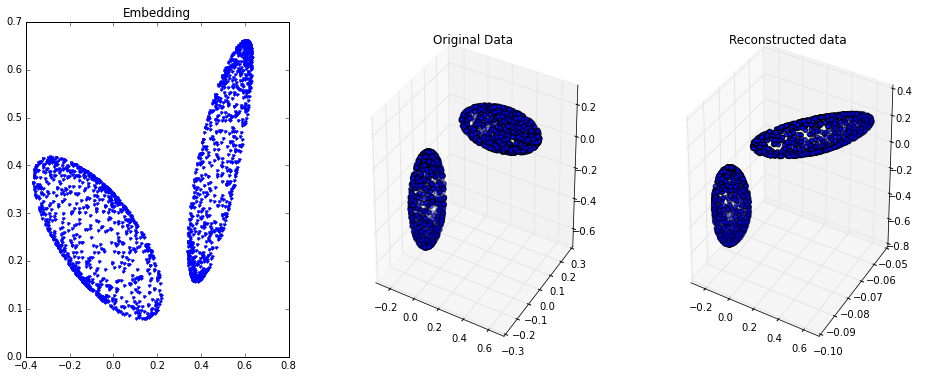

In [74]:
data = sphere([0.3,0.1,0.1], 1000) + [[0.3],[0.1],[0.1]]
data2 = sphere([0.1,0.1,0.3], 1000) - [[0.1],[0.1],[0.3]]
data = np.append(data, data2, axis=1)
ae = Autoencoder(data.shape[0],2)
ae.train(data, epochs=20, callback = cb_print)
ae.plot(data).show()

Next we use slightly different orientation of the spheres.

(0, ' sse=', 0.023625541927054048)
(5, ' sse=', 0.0067746013409730604)
(10, ' sse=', 0.0068052734289114521)
(15, ' sse=', 0.0069548761566349182)


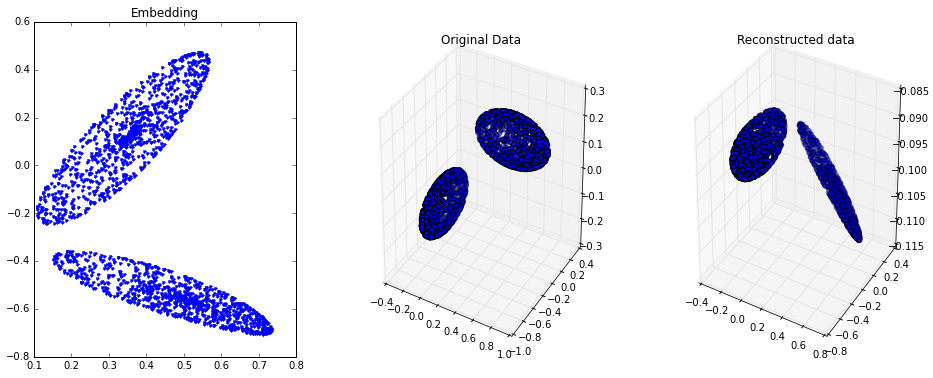

In [75]:
data = sphere([0.4,0.1,0.1], 1000) + [[0.4],[0.1],[0.1]]
data2 = sphere([0.1,0.4,0.1], 1000) - [[0.1],[0.4],[0.1]]
data = np.append(data, data2, axis=1)
ae = Autoencoder(data.shape[0],2)
ae.train(data, epochs=20, callback = cb_print)
ae.plot(data).show()

## 5.3 Training and testing elastic learning

In elastic learning we train one neuron after another and expand the hidden layer size elastically. 
In the implementation here we do this in an inefficent way: we just set the error for a neuron to 0, thereby masking its error and prohibiting backprop updates. Similarly we mask the output of a neuron in the forward step by setting it to 0. Note that this only works with $\tanh$ since $\tanh(0)=0$. So the modified training process looks like ($\cdot$ marks the element-wise product (Hadamard product)):

1. calculating the encoding of an example $x$ based on the model with Weights $W$ and bias $b$ as 
<div style="color:green;">
$$
y = o_{W,b}(x)\cdot mask_{forward}
$$
</div><p>
2. reconstructing the example $x$ based on the model with Weights $W^T$ and bias $b'$ as
$$
z = o_{W^{t},b'}(y)
$$
3. calculating the error between example $x$ and reconstruction of $x$ as
$$
\delta_o = (x-z)
$$
4. updating the model by going from the reconstructed output $z$ to the hidden layer representation $y$ to the input layer $x$  
   - Output Layer:
        $$
        b'= b'+ \eta * (1-z^2) * \delta_o
        $$
        $$
        W.T= W.T + \eta * ((1-z^2) \cdot \delta_o) * y^T
        $$
   - Hidden Layer with error <span style="color:green;"> $\delta_h = (W * \delta_o) * (1-z^2)\cdot mask_{error}$ </span>
   $$
   b = b + \eta * (1-y^2) * \delta_h
   $$
   $$
   W = W + \eta * ((1-y^2) \cdot \delta_h)*x^T
   $$

5. For every hidden neuron $h$, train (i.e. do steps 1-4 over a number of examples) with the following mask setting
   - $ \forall_{i\leq h}\;mask_{forward}[i] = 1$
   - $mask_{error}[h] = 1$



**Implementation:** Note that the curretn implemenation is an inefficient way to do elastic learnign, since we calculate the full matrix in every training step. For imporving efficiency one would need to cache internal hidden layer states ($y$) and reconstruction ($z$) per example.

Software technical the following code does a monkey patch to the Autoencoder class.

**Some notes on the obtained results: ** 
1. When training the second unit, we also get an update on the first unit from the output layer due to the forward mask used. In the experiments that seemed to be repsonsible for the correct implementation of the autoencoder.
2. From 1. follows, that updating the weights only once per example (either for the hidden layer or the output layer) seems to be sufficient. How it affects convergence is an open question.

In [76]:
def train_step_stochastic_elastic(self, x, fwd_mask, err_mask, eta=0.1):
    # data is a 1d array with exactly 1 example
    # forward phase
    y = self.encode(x) # input to hidden layer activation
    if self.log_elastic > 2: print "forward mask", y, y*fwd_mask
    y = y * fwd_mask   # mask the network forward step
    z = self.decode(y) # hidden layer to output layer activation. Note that the weights are shared
    # the error mask only activates a certain output
    err = (x - z) # error at the ouput layer
    self.b_rec = self.b_rec + eta * (1 - z**2) * err # update the bias terms into the reconstruction layer
    dwt = eta * np.matrix(((1 - z**2) * err)).T * np.matrix(y)  # a matrix update. one row for every neuron in the hidden layer
    err_h = np.sum(self.w * err,1)  # error of the hidden layer.
    if self.log_elastic > 2: print "backprop mask", err_h, err_h*err_mask
    err_h = err_h*err_mask
    if self.log_elastic > 3: print "bias update:", self.b ,"+", eta * (1 - y**2) * err_h
    self.b = self.b + eta * (1 - y**2) * err_h # update the bias terms into the hidden layer.
    if self.log_elastic > 3: 
        print "matrix update:", self.w 
        print "+", eta * np.matrix((1 - y**2) * err_h).T * np.matrix(x)
        print "+", dwt.T                              
    self.w = self.w + np.asarray(eta * np.matrix((1 - y**2) * err_h).T * np.matrix(x) + dwt.T) #
    return err

def train_elastic(self, data, epochs=20, eta=0.1, callback=None):
    for h in xrange(self.w.shape[0]): #iterate over hidden nodes
        err_mask = np.zeros(self.w.shape[0]) # error mask determines which neuron is trained
        err_mask[h] = 1.0
        fwd_mask = np.zeros(self.w.shape[0])
        fwd_mask[:h+1] = 1.0
        if self.log_elastic>0 : print "training hidden neuron ", h, " with err mask", err_mask," and fwd mask",  fwd_mask
        for j in xrange(epochs):
            sum_err = 0
            for i in xrange(data.shape[1]):
                err = self.train_step_stochastic_elastic(data[:,i], fwd_mask, err_mask, eta)    
                sum_err += np.sum(err**2)/data.shape[1]
            if callback!=None:
                callback(j,sum_err)
    return self    

#Monkey patch the autoencoder
Autoencoder.train_step_stochastic_elastic = train_step_stochastic_elastic
Autoencoder.train_elastic = train_elastic
Autoencoder.log_elastic = 0

### 5.3.1 Functional test of elastic learning

training hidden neuron  0  with err mask [ 1.]  and fwd mask [ 1.]
(0, ' sse=', 0.080855449721865064)
IT WORKS!!!!!!!


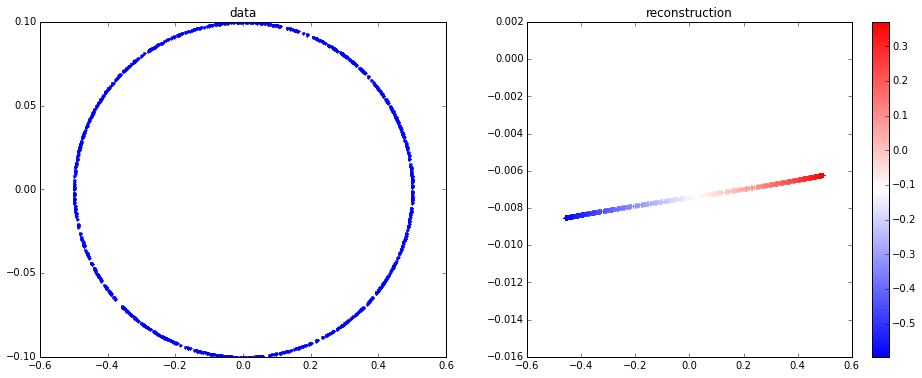

In [77]:
#nothing should change for a single hidden unit
Autoencoder.log_elastic = 1
data = circle([0.5,0.1],1000)
ae = Autoencoder(data.shape[0],1)
ae.train_elastic(data, epochs=5, callback = cb_print, eta=0.01)
ae.plot(data).show()
print "IT WORKS!!!!!!!"

### 5.3.2 Training an Elastic Autoencoder on a Sphere

The following code trains an elastic autoencoder on a sphere. It shows that the sphere can be well preserved. Their is no difference between the original trained AE and the elastically trained.

training hidden neuron  0  with err mask [ 1.  0.]  and fwd mask [ 1.  0.]
(0, ' sse=', 0.58106267213132257)
training hidden neuron  1  with err mask [ 0.  1.]  and fwd mask [ 1.  1.]
(0, ' sse=', 0.29982695578145119)


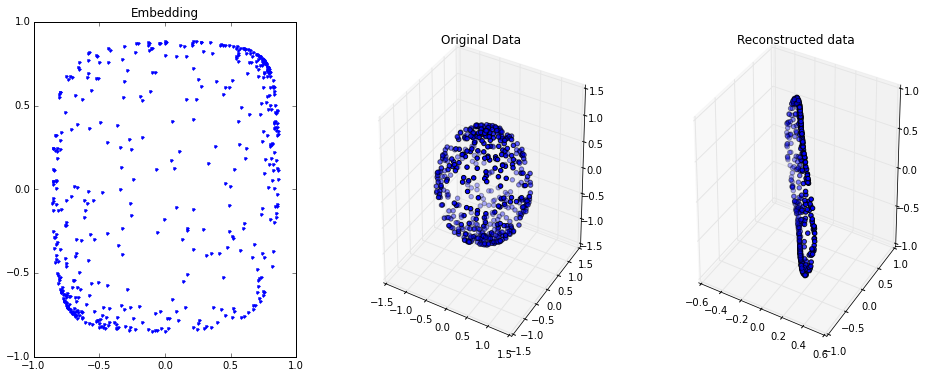

In [78]:
#uncoment the next two for seeing the updates happening
numpy.random.seed(12347)
#Autoencoder.log_elastic = 4
#data = sphere([1.0,1.0,1.0],5)
Autoencoder.log_elastic = 1
data = sphere([1.0,1.0,1.0],500)
ae = Autoencoder(data.shape[0],2)
ae.train_elastic(data, epochs=5, callback = cb_print)
ae.plot(data).show()

### 5.3.3 Training an Elastic Autoencoder on a Bi-Sphere

The following code trains an elastic autoencoder on a bi-sphere. It shows that both spheres can be well preserved. Their is no difference between the original trained AE and the elastically trained.

training hidden neuron  0  with err mask [ 1.  0.]  and fwd mask [ 1.  0.]
(0, ' sse=', 0.021865018109992095)
(5, ' sse=', 0.01741240591862786)
(10, ' sse=', 0.01749485883327731)
(15, ' sse=', 0.017502939903178763)
training hidden neuron  1  with err mask [ 0.  1.]  and fwd mask [ 1.  1.]
(0, ' sse=', 0.010488808384599294)
(5, ' sse=', 0.003353073475772675)
(10, ' sse=', 0.0032024941697774852)
(15, ' sse=', 0.0032043263962511005)


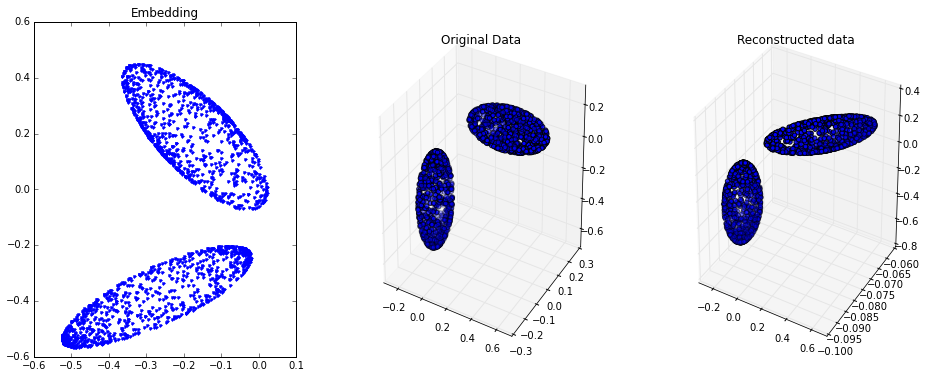

In [80]:
Autoencoder.log_elastic = 1
data = sphere([0.3,0.1,0.1], 1000) + [[0.3],[0.1],[0.1]]
data2 = sphere([0.1,0.1,0.3], 1000) - [[0.1],[0.1],[0.3]]
data = np.append(data, data2, axis=1)
ae = Autoencoder(data.shape[0],2)
ae.train_elastic(data, epochs=20, callback = cb_print)
ae.plot(data).show()

## 5.4 Truly Elastic training - no weight updates to previous units 

In addition to the application of the masks in the previous elastic setting, we also apply the $mask_{error}$ to the  update of the output layer. This suppresses updating any weight of previously learned weights. So we get the following error estimate in step 3 above:

Update Outputlayer<span style="color:green;"> 
$$
        W.T= W.T + \eta * ((1-z^2) \cdot \delta_o) * (y\cdot mask_{error})^T
        $$
</span>

In [81]:
def train_step_stochastic_elastic2(self, x, fwd_mask, err_mask, eta=0.1):
    # data is a 1d array with exactly 1 example
    # forward phase
    y = self.encode(x) # input to hidden layer activation
    if self.log_elastic > 2: print "forward mask", y, y*fwd_mask, y*err_mask
    y = y * fwd_mask   # mask the network forward step
    z = self.decode(y) # hidden layer to output layer activation. Note that the weights are shared
    # the error mask only activates a certain output
    err = (x - z) # error at the ouput layer
    self.b_rec = self.b_rec + eta * (1 - z**2) * err # update the bias terms into the reconstruction layer
    dwt = eta * np.matrix(((1 - z**2) * err)).T * np.matrix(y*err_mask)  # a matrix update. one row for every neuron in the hidden layer
    err_h = np.sum(self.w * err,1)  # error of the hidden layer.
    if self.log_elastic > 2: print "backprop mask", err_h, err_h*err_mask
    err_h = err_h*err_mask
    if self.log_elastic > 3: print "bias update:", self.b ,"+", eta * (1 - y**2) * err_h
    self.b = self.b + eta * (1 - y**2) * err_h # update the bias terms into the hidden layer.
    if self.log_elastic > 3: 
        print "matrix update:", self.w 
        print "+", eta * np.matrix((1 - y**2) * err_h).T * np.matrix(x)
        print "+", dwt.T
    self.w = self.w + np.asarray(eta * np.matrix((1 - y**2) * err_h).T * np.matrix(x) + dwt.T) #
    return err

def train_elastic2(self, data, epochs=20, eta=0.1, callback=None):
    for h in xrange(self.w.shape[0]): #iterate over hidden nodes
        err_mask = np.zeros(self.w.shape[0]) # error mask determines which neuron is trained
        err_mask[h] = 1.0
        fwd_mask = np.zeros(self.w.shape[0])
        fwd_mask[:h+1] = 1.0
        if self.log_elastic>0 : print "training hidden neuron ", h, " with err mask", err_mask," and fwd mask",  fwd_mask
        for j in xrange(epochs):
            sum_err = 0
            for i in xrange(data.shape[1]):
                err = self.train_step_stochastic_elastic2(data[:,i], fwd_mask, err_mask, eta)    
                sum_err += np.sum(err**2)/data.shape[1]
            if callback!=None:
                callback(j,sum_err)
    return self    

#Monkey patch the autoencoder
Autoencoder.train_step_stochastic_elastic2 = train_step_stochastic_elastic2
Autoencoder.train_elastic2 = train_elastic2
Autoencoder.log_elastic = 0

### 5.4.1 Embedding a sphere - looks like traditional AEs and Elastic1

The following code embeds a sphere again. The results are the same as in the case of the autoencoder and the elastic1 variant. 

training hidden neuron  0  with err mask [ 1.  0.]  and fwd mask [ 1.  0.]
(0, ' sse=', 0.58106267213132257)
training hidden neuron  1  with err mask [ 0.  1.]  and fwd mask [ 1.  1.]
(0, ' sse=', 0.30995999442292954)


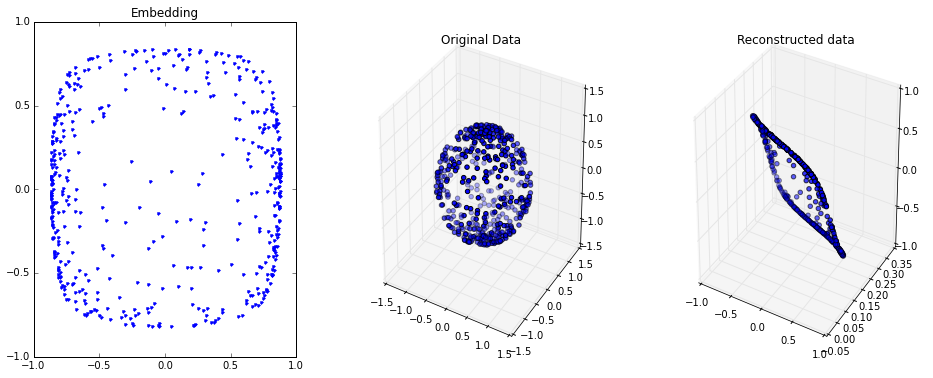

In [82]:
#uncoment the next two for seeing the updates happening
numpy.random.seed(12347)
#Autoencoder.log_elastic = 4
#data = sphere([1.0,1.0,1.0],5)
Autoencoder.log_elastic = 1
data = sphere([1.0,1.0,1.0],500)
ae = Autoencoder(data.shape[0],2)
ae.train_elastic2(data, epochs=5, callback = cb_print)
ae.plot(data).show()

### 5.4.2 Embedding a Bi-Sphere - Elastic 2 choose directions of greatest variance (!?!)

The following code embeds a bi-sphere. At the first glance they look similar to the traditional AE, however, on a closer look they are orthogonal to each other. This corresponds to a PCA based projection

training hidden neuron  0  with err mask [ 1.  0.]  and fwd mask [ 1.  0.]
(0, ' sse=', 0.02512105148028819)
(5, ' sse=', 0.017511604594007087)
(10, ' sse=', 0.017504699981484826)
(15, ' sse=', 0.017503952610357681)
training hidden neuron  1  with err mask [ 0.  1.]  and fwd mask [ 1.  1.]
(0, ' sse=', 0.0089082987380481159)
(5, ' sse=', 0.0038665336043683688)
(10, ' sse=', 0.0037993493784037064)
(15, ' sse=', 0.0037540392522657524)


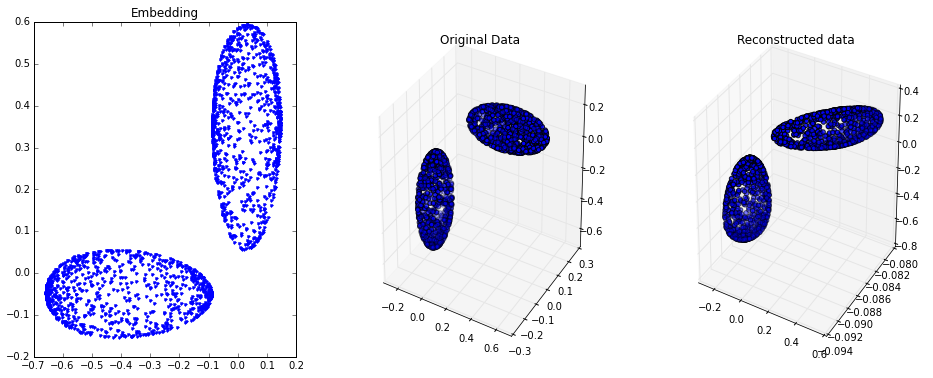

In [83]:
Autoencoder.log_elastic = 1
data = sphere([0.3,0.1,0.1], 1000) + [[0.3],[0.1],[0.1]]
data2 = sphere([0.1,0.1,0.3], 1000) - [[0.1],[0.1],[0.3]]
data = np.append(data, data2, axis=1)
ae = Autoencoder(data.shape[0],2)
ae.train_elastic2(data, epochs=20, callback = cb_print)
ae.plot(data).show()

Compare with the elastic 1 version (which is similar to AE).

training hidden neuron  0  with err mask [ 1.  0.]  and fwd mask [ 1.  0.]
(0, ' sse=', 0.021865018109992095)
(5, ' sse=', 0.01741240591862786)
(10, ' sse=', 0.01749485883327731)
(15, ' sse=', 0.017502939903178763)
training hidden neuron  1  with err mask [ 0.  1.]  and fwd mask [ 1.  1.]
(0, ' sse=', 0.010488808384599294)
(5, ' sse=', 0.003353073475772675)
(10, ' sse=', 0.0032024941697774852)
(15, ' sse=', 0.0032043263962511005)


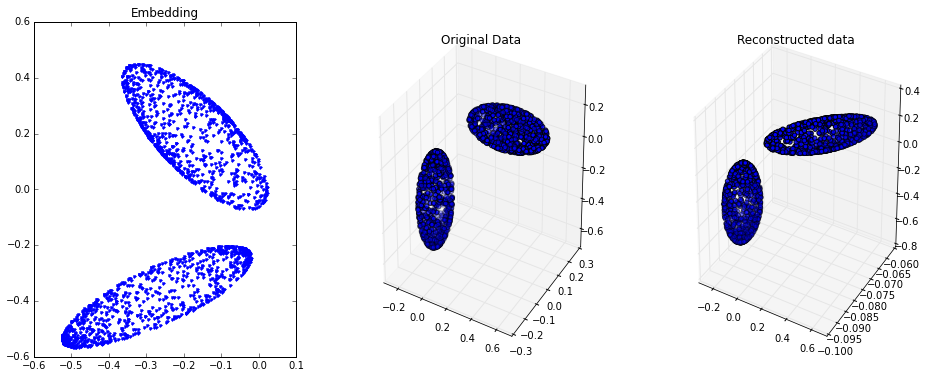

In [84]:
# now train elastic 1 version, which is the same as a regular autoencoder
Autoencoder.log_elastic = 1
data = sphere([0.3,0.1,0.1], 1000) + [[0.3],[0.1],[0.1]]
data2 = sphere([0.1,0.1,0.3], 1000) - [[0.1],[0.1],[0.3]]
data = np.append(data, data2, axis=1)
ae = Autoencoder(data.shape[0],2)
ae.train_elastic(data, epochs=20, callback = cb_print)
ae.plot(data).show()

Now we change the directions of the spheres in two direction to study the effect with elastic1

training hidden neuron  0  with err mask [ 1.  0.]  and fwd mask [ 1.  0.]
(0, ' sse=', 0.047422660745803966)
(5, ' sse=', 0.028632872691778513)
(10, ' sse=', 0.028586853216083837)
(15, ' sse=', 0.028576590939764092)
training hidden neuron  1  with err mask [ 0.  1.]  and fwd mask [ 1.  1.]
(0, ' sse=', 0.015752899220600521)
(5, ' sse=', 0.014914466302216199)
(10, ' sse=', 0.014881020572452787)
(15, ' sse=', 0.014887349545430945)


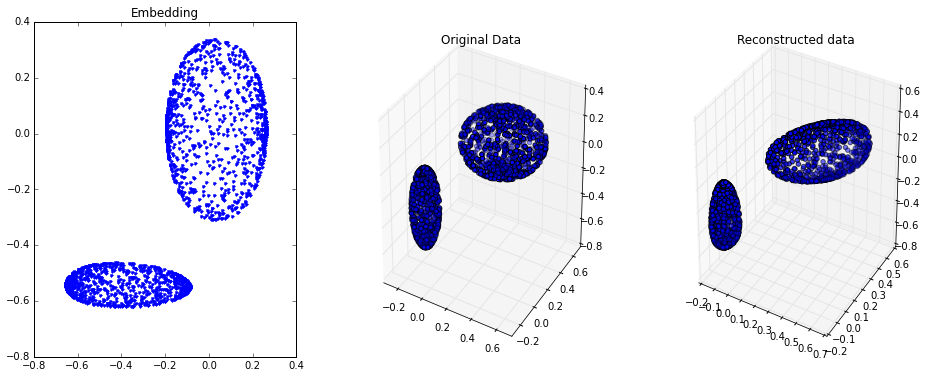

In [89]:
Autoencoder.log_elastic = 1
data = sphere([0.3,0.3,0.2], 1000) + [[0.3],[0.3],[0.1]]
data2 = sphere([0.1,0.1,0.3], 1000) - [[0.1],[0.1],[0.3]]
data = np.append(data, data2, axis=1)
ae = Autoencoder(data.shape[0],2)
ae.train_elastic2(data, epochs=20, callback = cb_print)
ae.plot(data).show()

and now for elastic 2

training hidden neuron  0  with err mask [ 1.  0.]  and fwd mask [ 1.  0.]
(0, ' sse=', 0.035897576001275147)
(5, ' sse=', 0.028586689303882754)
(10, ' sse=', 0.028563203407875232)
(15, ' sse=', 0.028563244586375464)
training hidden neuron  1  with err mask [ 0.  1.]  and fwd mask [ 1.  1.]
(0, ' sse=', 0.017138534543842308)
(5, ' sse=', 0.013985205815548133)
(10, ' sse=', 0.014028917669809061)
(15, ' sse=', 0.014077218599107958)


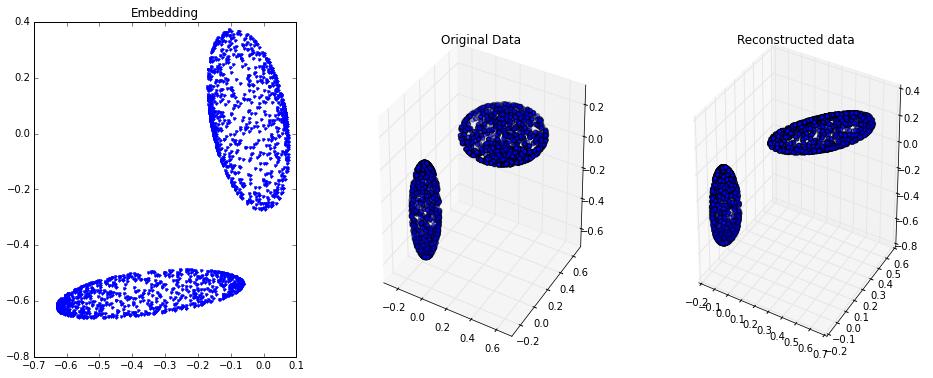

In [88]:
Autoencoder.log_elastic = 1
data = sphere([0.3,0.3,0.1], 1000) + [[0.3],[0.3],[0.1]]
data2 = sphere([0.1,0.1,0.3], 1000) - [[0.1],[0.1],[0.3]]
data = np.append(data, data2, axis=1)
ae = Autoencoder(data.shape[0],2)
ae.train_elastic(data, epochs=20, callback = cb_print)
ae.plot(data).show()

#References

